In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def parse_flight_leg_exp(path: str) -> pd.DataFrame:
    flight_leg_exp = pd.read_csv(path, parse_dates=[1, 2, 8, 9, 10, 11, 12, 13, 14, 15])
    return flight_leg_exp

In [3]:
#path = 'data/flight_leg_exp_joined_with_metar.csv'
path = 'data/flight_leg_exp_joined_with_metar_flight_time_treated_as_utc.csv'
flight_leg_exp = parse_flight_leg_exp(path)

In [4]:
flight_leg_exp.columns

Index(['FLIGHT_NUMBER', 'ORIGINAL_FLIGHT_DATE', 'FLIGHT_DATE',
       'LEG_SEQUENCE_NUBMBER', 'PUB_DEPARTURE_AIRPORT_CODE',
       'PUB_ARRIVAL_AIRPORT_CODE', 'DEPARTURE_AIRPORT_CODE',
       'ARRIVAL_AIRPORT_CODE', 'BLOCK_OFF_DATE_TIME', 'TAKE_OFF_DATE_TIME',
       'LANDING_DATE_TIME', 'BLOCK_ON_DATE_TIME', 'SCH_START_DATE_TIME',
       'SCH_END_DATE_TIME', 'ESTIMATED_START_DATE_TIME',
       'ESTIMATED_END_DATE_TIME', 'TAIL_NUMBER', 'DISPLAY_CODE', 'IS_FROM_SVO',
       'LAST_METAR_REPORT_TIME', 'code', 'mod', 'wind_speed_mps',
       'wind_gust_mps', 'wind_dir', 'wind_dir_from', 'wind_dir_to', 'vis',
       'additional_vis', 'additional_vis_dir', 'runway_visual_range_from',
       'runway_visual_range_to', 'temp', 'dewpt', 'press', 'sky_conditions',
       'present_weather', 'first_layer_coverage', 'first_layer_height',
       'first_layer_CB', 'first_layer_TCU', 'second_layer_coverage',
       'second_layer_height', 'second_layer_CB', 'second_layer_TCU',
       'clouds_hidden', 'v

In [5]:
df = flight_leg_exp.copy()

In [6]:
def check_nulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(len(data.columns))
    return missing_data

In [7]:
check_nulls(df)

,Total,Percent
additional_vis_dir,844596,0.992243
additional_vis,844586,0.992231
runway_visual_range_to,839066,0.985746
runway_visual_range_from,839066,0.985746
wind_gust_mps,820419,0.963839
wind_dir_from,791942,0.930384
wind_dir_to,791942,0.930384
present_weather,645843,0.758745
sky_conditions,358183,0.420798
wind_dir,59744,0.070188


Есть фичи, которые достаточно часто принимают значение NaN, это столбцы:
* **additional_vis_dir** - направление в котором видимость сильно меньше (азимут), nullable
* **additional_vis** - если в каком-то направлении видимость сильно меньше, то ее значение в метрах, nullable
* **runway_visual_range_to** - горизонтальная видимость на полосе (до), nullable
* **runway_visual_range_from** - горизонтальная видимость на полосе (от), nullable
* **wind_gust_mps** - порывы ветра в метрах в секунду, nullable
* **wind_dir_from** - если направление меняется, то в каких пределах (от), nullable
* **wind_dir_to** - если направление меняется, то в каких пределах (до), nullable
* **present_weather** - читаемая человеком строка, описывающая явления погоды, nullable
* **sky_conditions** - читаемая человеком строка, описывающая облачность, nullable
* **wind_dir** - направление ветра (азимут) в градусах, nullable


\* nullable - значение может отсутствовать (пустая строка)

Остальные признаки имеют значения NaN меньше, чем в 1% случаев.
Поэтому перечисленные выше признаки будут исключены из дальнейшего рассмотрения.

In [8]:
df.drop(['additional_vis_dir', 'additional_vis', 'runway_visual_range_to', 
         'runway_visual_range_from', 'wind_gust_mps', 'wind_dir_from', 
         'wind_dir_to', 'present_weather', 'sky_conditions', 'wind_dir'], axis=1, inplace=True)

Проверим признаки погоды на валидность с другой стороны - не имеет смысла использовать признаки, которые имеют только одно уникальное значение, или которые являются строками, не относящимся непосредственно к рейсам или погодным условиям.

In [9]:
for col in df.columns:
    print(df[col].value_counts(dropna=False).head())

261     1638
260     1618
1731    1443
102     1439
1482    1438
Name: FLIGHT_NUMBER, dtype: int64
2017-08-18    719
2017-08-19    718
2017-08-05    716
2017-08-20    716
2017-07-30    714
Name: ORIGINAL_FLIGHT_DATE, dtype: int64
2017-08-18    719
2017-08-19    718
2017-08-05    716
2017-08-20    716
2017-07-30    714
Name: FLIGHT_DATE, dtype: int64
100    847135
200      4046
300        10
150         4
50          3
Name: LEG_SEQUENCE_NUBMBER, dtype: int64
SVO    424523
LED     25356
AER     10183
SVX      9810
KRR      9632
Name: PUB_DEPARTURE_AIRPORT_CODE, dtype: int64
SVO    425406
LED     25319
AER     10178
SVX      9777
KRR      9617
Name: PUB_ARRIVAL_AIRPORT_CODE, dtype: int64
SVO    424523
LED     25358
AER     10183
SVX      9813
KRR      9637
Name: DEPARTURE_AIRPORT_CODE, dtype: int64
SVO    425360
LED     25335
AER     10172
SVX      9783
KRR      9616
Name: ARRIVAL_AIRPORT_CODE, dtype: int64
NaT                    125
2016-10-05 16:28:00      7
2013-09-19 17:40:00      6


 0.0    849597
NaN       1510
 1.0        92
Name: nearby thunderstorm, dtype: int64
 0.0    849689
NaN       1510
Name: rain and snow, dtype: int64


Далее описаны столбцы, которые имеют либо строчные значения, не имеющие отношение к рейсам, либо столбцы с единственным уникальным значением. Эти столбцы также будут исключены из дальнейшей работы.
* **LAST_METAR_REPORT_TIME** - время UTC (замеры каждые 30 минут)
* **code** - исходная METAR-строка
* **mod** - строка или “AUTO” (автоматический отчет) или “COR” (вручную скорректированный)
* **second_layer_TCU** - является ли нижний слой башенкообразным (0 или 1)
Из оставшихся каждый столбец - отдельное явление погоды (такие как дождь, сильный дождь, град, снег, метель, туман, дымка...) (1 - если явление наблюдается, 0 иначе), в данном датасете явления не наблюдались:
* **light ice pellets showers**
* **rain and snow**

Более того, есть много природных явлений, которые появляются не более, чем в 1000 строках, что может означать, что это крайне редкие явления, и не сильно помогут в дальнейшем прогнозировании. Не понятно, имеет смысл оставлять такие, если появлений меньше 100, или нет, но пусть будут, потом посмотрим, является ли каждый из них существенным для задержки рейса.
* **snow and rain** - 21
* **freezing rain** - 56
* **heavy snow** - 137
* **light snow pellets showers** - 87
* **light snow and snow pellets showers** - 58
* **light snow and rain showers** - 527
* **snow and snow pellets showers** - 14
* **light rain and snow showers** - 418
* **light snow grains** - 181
* **patches of fog** - 339
* **rain** - 23
* **light freezing rain and snow** - 8
* **light snow and rain** - 665
* **light thunderstorm with rain and hail** - 17
* **thunderstorm with rain** - 13
* **light ice pellets** - 156
* **haze** - 302
* **ice crystals** - 548
* **ice pellets** - 22
* **snow pellets showers** - 29
* **light rain and snow pellets showers** - 38
* **thunderstorm** - 788
* **freezing rain and snow** - 6
* **drizzle** - 49
* **smoke** - 81
* **heavy thunderstorm with rain and hail** - 19
* **light thunderstorm with snow** - 11
* **snow and snow pellets** - 28
* **nearby thunderstorm** - 77

df['rain_sum'] = df[['snow and rain', 'freezing rain', 'light rain', 'light snow and rain showers',
                     'light rain and snow showers', 'rain', 'light freezing rain and snow', 
                     'light freezing rain', 'light snow and rain', 'thunderstorm with rain',
                     'light freezing drizzle', 'light rain and snow pellets showers', 
                     'freezing rain and snow', 'drizzle', 'light rain showers',
                     'heavy thunderstorm with rain and hail', 'light drizzle', 'light rain and snow',
                     'light thunderstorm with rain', 
                    ]].sum(axis=1)

df['snow_sum'] = df[['snow and rain', 'snow showers', 'heavy snow', 'light snow pellets showers', 
                     'light snow and snow pellets showers', 'light snow and rain showers',
                     'snow and snow pellets showers', 'light snow', 'light rain and snow showers', 
                     'light snow grains', 'light snow showers', 'light freezing rain and snow',
                     'light snow and rain', 'snow', 'light ice pellets','low drifting snow', 
                     'ice crystals', 'ice pellets', 'snow pellets showers', 'heavy snow showers',
                     'light rain and snow pellets showers', 'freezing rain and snow', 
                     'light thunderstorm with snow', 'light rain and snow', 'blowing snow', 
                     'snow and snow pellets',
                    ]].sum(axis=1)

df['fog_sum'] = df[['fog', 'patches of fog', 'mist', 'haze', 'freezing fog', 'smoke', 
                    'shallow fog', ]].sum(axis=1)

df['thunderstorm_sum'] = df[['light thunderstorm with rain and hail', 'thunderstorm with rain', 
                             'thunderstorm', 'heavy thunderstorm with rain and hail', 
                             'light thunderstorm with snow', 'light thunderstorm with rain', 
                             'nearby thunderstorm', 
                            ]].sum(axis=1)

df['hail_sum'] = df[['light thunderstorm with rain and hail', 'heavy thunderstorm with rain and hail',
                     ]].sum(axis=1)


In [10]:
df.drop(['LAST_METAR_REPORT_TIME', 'code', 'mod', 'second_layer_TCU', 
         'light ice pellets showers', 'rain and snow',], axis=1, inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(848508, 80)

Проверим, есть ли в данных такое, что время вылета (по расписанию) больше, чем время прилёта

In [13]:
duration = df.SCH_END_DATE_TIME - df.SCH_START_DATE_TIME
duration.min()

Timedelta('-5 days +10:25:00')

Это соответствует рейсу

In [14]:
df[df.SCH_END_DATE_TIME - df.SCH_START_DATE_TIME == duration.min()]

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,snow,light ice pellets,haze,light freezing drizzle,freezing fog,low drifting snow,ice crystals,ice pellets,snow pellets showers,heavy snow showers,light rain and snow pellets showers,thunderstorm,freezing rain and snow,drizzle,smoke,light rain showers,heavy thunderstorm with rain and hail,light drizzle,light thunderstorm with snow,light rain and snow,light thunderstorm with rain,blowing snow,snow and snow pellets,shallow fog,nearby thunderstorm
131115,1771,2014-03-15,2014-03-15,200,KJA,SVO,KJA,SVO,2014-03-21 00:05:00,2014-03-21 00:18:00,2014-03-21 05:35:00,2014-03-21 05:41:00,2014-03-20 00:05:00,2014-03-15 10:30:00,2014-03-21 00:05:00,2014-03-21 05:45:00,96015,SVOIL96SU,False,2.0,10000.0,-6.0,-8.0,1002.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим, сколько таких

In [15]:
critical_point = datetime.timedelta(0)
df[df.SCH_END_DATE_TIME - df.SCH_START_DATE_TIME <= critical_point].shape

(707, 80)

Не так уж и много, удаляем

In [16]:
df = df[df.SCH_END_DATE_TIME - df.SCH_START_DATE_TIME > critical_point]

In [17]:
df.shape

(847801, 80)

Проверим, есть ли такая же тенденция отричательного времени полёта для фактического времени вылета и прилёта

In [18]:
duration = df.BLOCK_ON_DATE_TIME - df.BLOCK_OFF_DATE_TIME
duration.min()

Timedelta('-1 days +09:26:00')

Count

In [19]:
sum(df.BLOCK_ON_DATE_TIME - df.BLOCK_OFF_DATE_TIME <= critical_point)

10

Удалим

In [20]:
df = df[df.BLOCK_ON_DATE_TIME - df.BLOCK_OFF_DATE_TIME > critical_point]
df.shape

(847791, 80)

In [21]:
df[df.ARRIVAL_AIRPORT_CODE == 'NRT'].tail()

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,snow,light ice pellets,haze,light freezing drizzle,freezing fog,low drifting snow,ice crystals,ice pellets,snow pellets showers,heavy snow showers,light rain and snow pellets showers,thunderstorm,freezing rain and snow,drizzle,smoke,light rain showers,heavy thunderstorm with rain and hail,light drizzle,light thunderstorm with snow,light rain and snow,light thunderstorm with rain,blowing snow,snow and snow pellets,shallow fog,nearby thunderstorm
849170,264,2017-08-16,2017-08-16,200,SVO,NRT,SVO,NRT,2017-08-16 16:03:00,2017-08-16 16:11:00,2017-08-17 01:07:00,2017-08-17 01:12:00,2017-08-16 16:00:00,2017-08-17 01:35:00,2017-08-16 16:00:00,2017-08-17 01:23:00,VPBDD,SVOA3KRSU,True,4.0,10000.0,22.0,12.0,1027.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
849571,262,2017-07-30,2017-07-30,200,SVO,NRT,SVO,NRT,2017-07-30 16:02:00,2017-07-30 16:20:00,2017-07-31 01:20:00,2017-07-31 01:37:00,2017-07-30 16:00:00,2017-07-31 01:35:00,2017-07-30 16:00:00,2017-07-31 01:36:00,VQBQZ,SVOA3KRSU,True,4.0,10000.0,20.0,18.0,1004.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
849802,260,2017-08-03,2017-08-03,200,SVO,NRT,SVO,NRT,2017-08-03 17:26:00,2017-08-03 17:50:00,2017-08-04 02:31:00,2017-08-04 02:49:00,2017-08-03 16:00:00,2017-08-04 01:35:00,2017-08-03 17:30:00,2017-08-04 02:47:00,VPBDD,SVOA3KRSU,True,5.0,10000.0,23.0,14.0,1011.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
850360,260,2017-07-31,2017-07-31,200,SVO,NRT,SVO,NRT,2017-07-31 16:13:00,2017-07-31 16:31:00,2017-08-01 01:33:00,2017-08-01 01:42:00,2017-07-31 16:00:00,2017-08-01 01:35:00,2017-07-31 16:00:00,2017-08-01 01:49:00,VQBPJ,SVOA3KRSU,True,5.0,10000.0,24.0,13.0,1013.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
850804,260,2017-07-27,2017-07-27,200,SVO,NRT,SVO,NRT,2017-07-27 16:08:00,2017-07-27 16:28:00,2017-07-28 01:22:00,2017-07-28 01:42:00,2017-07-27 16:00:00,2017-07-28 01:35:00,2017-07-27 16:00:00,2017-07-28 01:38:00,VQBEL,SVOA333SU,True,6.0,10000.0,24.0,15.0,1008.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Судя по всему, время указано в UTC. 

Можно сравнить *ESTIMATED_START_DATE_TIME* и *ESTIMATED_END_DATE_TIME* с тем, что представлено на сайте Аэрофлот
<img src="img/svo-nrt.png">

Добавим информации об аэропортах - координаты, тип аэропорта

In [22]:
airports = pd.read_csv('airports.csv')
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [23]:
check_nulls(airports)

,Total,Percent
home_link,50370,0.945738
keywords,45557,0.855370
iata_code,44151,0.828971
wikipedia_link,43722,0.820916
continent,27024,0.507398
local_code,24982,0.469057
gps_code,12208,0.229215
elevation_ft,6112,0.114758
municipality,5569,0.104563
iso_country,247,0.004638


для анализа и построения графиков хватит атрибутов *type, latitude_deg, longitude_deg, iata_code*

In [24]:
airports = airports[['type', 'latitude_deg', 'longitude_deg', 'iata_code', 'iso_country', 'scheduled_service']]

Преобразуем переменные: 
* **type** - one-hot
* **scheduled_service** - no: 0, yes: 1

Остальные оставим

In [25]:
# scheduled_service - замена
services = {"yes": 1, "no": 0}
airports["scheduled_service"] = airports["scheduled_service"].apply(lambda s: services.get(s))

# type - расширение
type_dummies = pd.get_dummies(airports["type"], prefix="type", dummy_na=False)
airports = pd.concat([airports, type_dummies], axis=1)

airports.drop(['type', 'type_balloonport', 'type_heliport', 'type_seaplane_base'], axis=1, inplace=True)

In [26]:
airports.head()

,latitude_deg,longitude_deg,iata_code,iso_country,scheduled_service,type_closed,type_large_airport,type_medium_airport,type_small_airport
0,40.070801,-74.933601,NaN,US,0,0,0,0,0
1,38.704022,-101.473911,NaN,US,0,0,0,0,1
2,59.949200,-151.695999,NaN,US,0,0,0,0,1
3,34.864799,-86.770302,NaN,US,0,0,0,0,1
4,35.608700,-91.254898,NaN,US,0,1,0,0,0


In [27]:
df = pd.merge(df, airports, left_on='PUB_DEPARTURE_AIRPORT_CODE', right_on='iata_code')
df = pd.merge(df, airports, left_on='PUB_ARRIVAL_AIRPORT_CODE', right_on='iata_code', suffixes=['_out', '_in'])

In [28]:
df.head()

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,light thunderstorm with snow,light rain and snow,light thunderstorm with rain,blowing snow,snow and snow pellets,shallow fog,nearby thunderstorm,latitude_deg_out,longitude_deg_out,iata_code_out,iso_country_out,scheduled_service_out,type_closed_out,type_large_airport_out,type_medium_airport_out,type_small_airport_out,latitude_deg_in,longitude_deg_in,iata_code_in,iso_country_in,scheduled_service_in,type_closed_in,type_large_airport_in,type_medium_airport_in,type_small_airport_in
0,1125,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 14:41:00,2013-04-26 14:56:00,2013-04-26 17:19:00,2013-04-26 17:29:00,2013-04-26 14:45:00,2013-04-26 17:05:00,2013-04-26 14:45:00,2013-04-26 17:20:00,VPBWI,SVOA320SU,False,6.0,10000.0,11.0,-4.0,1010.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0
1,1127,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 17:14:00,2013-04-26 17:25:00,2013-04-26 19:48:00,2013-04-26 19:52:00,2013-04-26 17:20:00,2013-04-26 19:45:00,2013-04-26 17:20:00,2013-04-26 19:58:00,VPBQV,SVOA320SU,False,3.0,10000.0,9.0,-3.0,1009.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0
2,1123,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 09:42:00,2013-04-26 09:56:00,2013-04-26 12:20:00,2013-04-26 12:31:00,2013-04-26 09:45:00,2013-04-26 12:00:00,2013-04-26 09:45:00,2013-04-26 12:25:00,VQBIW,SVOA320SU,False,6.0,10000.0,10.0,-1.0,1012.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0
3,1129,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 01:55:00,2013-04-26 02:09:00,2013-04-26 04:25:00,2013-04-26 04:33:00,2013-04-26 02:05:00,2013-04-26 04:30:00,2013-04-26 02:05:00,2013-04-26 04:35:00,VQBCO,SVOA319SU,False,3.0,10000.0,2.0,0.0,1011.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0
4,1139,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 08:06:00,2013-04-26 08:15:00,2013-04-26 10:31:00,2013-04-26 10:37:00,2013-04-26 08:15:00,2013-04-26 10:40:00,2013-04-26 08:15:00,2013-04-26 10:41:00,VPBQW,SVOA320SU,False,6.0,10000.0,10.0,0.0,1012.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0


In [30]:
check_nulls(df).head()

,Total,Percent
type_small_airport_in,0,0.0
first_layer_coverage,0,0.0
first_layer_CB,0,0.0
first_layer_TCU,0,0.0
second_layer_coverage,0,0.0


**Построить график карту**

Переводим все временные отметки в минуты, начиная с заданной начальной точки

In [31]:
start_point = datetime.datetime(2012,1,1)

df['SCH_START_DATE_TIME' + '_MIN'] = df.SCH_START_DATE_TIME.apply(lambda x: (x-start_point).total_seconds() // 60)
df['SCH_END_DATE_TIME' + '_MIN'] = df.SCH_END_DATE_TIME.apply(lambda x: (x-start_point).total_seconds() // 60)
df['BLOCK_ON_DATE_TIME' + '_MIN'] = df.BLOCK_ON_DATE_TIME.apply(lambda x: (x-start_point).total_seconds() // 60)
# надо ли оставшиеся? вроде нет
#df['FLIGHT_DATE' + '_MIN'] = df.FLIGHT_DATE.apply(lambda x: (x-start_point).total_seconds() // 60)
df.head()

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,blowing snow,snow and snow pellets,shallow fog,nearby thunderstorm,latitude_deg_out,longitude_deg_out,iata_code_out,iso_country_out,scheduled_service_out,type_closed_out,type_large_airport_out,type_medium_airport_out,type_small_airport_out,latitude_deg_in,longitude_deg_in,iata_code_in,iso_country_in,scheduled_service_in,type_closed_in,type_large_airport_in,type_medium_airport_in,type_small_airport_in,SCH_START_DATE_TIME_MIN,SCH_END_DATE_TIME_MIN,BLOCK_ON_DATE_TIME_MIN
0,1125,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 14:41:00,2013-04-26 14:56:00,2013-04-26 17:19:00,2013-04-26 17:29:00,2013-04-26 14:45:00,2013-04-26 17:05:00,2013-04-26 14:45:00,2013-04-26 17:20:00,VPBWI,SVOA320SU,False,6.0,10000.0,11.0,-4.0,1010.0,0.0,...,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0,693525.0,693665.0,693689.0
1,1127,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 17:14:00,2013-04-26 17:25:00,2013-04-26 19:48:00,2013-04-26 19:52:00,2013-04-26 17:20:00,2013-04-26 19:45:00,2013-04-26 17:20:00,2013-04-26 19:58:00,VPBQV,SVOA320SU,False,3.0,10000.0,9.0,-3.0,1009.0,0.0,...,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0,693680.0,693825.0,693832.0
2,1123,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 09:42:00,2013-04-26 09:56:00,2013-04-26 12:20:00,2013-04-26 12:31:00,2013-04-26 09:45:00,2013-04-26 12:00:00,2013-04-26 09:45:00,2013-04-26 12:25:00,VQBIW,SVOA320SU,False,6.0,10000.0,10.0,-1.0,1012.0,6.0,...,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0,693225.0,693360.0,693391.0
3,1129,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 01:55:00,2013-04-26 02:09:00,2013-04-26 04:25:00,2013-04-26 04:33:00,2013-04-26 02:05:00,2013-04-26 04:30:00,2013-04-26 02:05:00,2013-04-26 04:35:00,VQBCO,SVOA319SU,False,3.0,10000.0,2.0,0.0,1011.0,0.0,...,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0,692765.0,692910.0,692913.0
4,1139,2013-04-26,2013-04-26,100,AER,SVO,AER,SVO,2013-04-26 08:06:00,2013-04-26 08:15:00,2013-04-26 10:31:00,2013-04-26 10:37:00,2013-04-26 08:15:00,2013-04-26 10:40:00,2013-04-26 08:15:00,2013-04-26 10:41:00,VPBQW,SVOA320SU,False,6.0,10000.0,10.0,0.0,1012.0,3.0,...,0.0,0.0,0.0,0.0,43.449902,39.9566,AER,RU,1,0,1,0,0,55.972599,37.4146,SVO,RU,1,0,1,0,0,693135.0,693280.0,693277.0


In [32]:
df['SCH_TIME_IN_OUT_SVO'] = df.apply(lambda x: x.SCH_START_DATE_TIME if x.IS_FROM_SVO == True else x.SCH_END_DATE_TIME, axis=1)

In [33]:
df.sort_values(by='SCH_START_DATE_TIME', inplace=True)

In [34]:
unique_planes = list(set(df.TAIL_NUMBER))
dict_tail_sch_svo = dict()
dict_tail_sch_not_svo = dict()
dict_tail_fact_svo = dict()
dict_tail_fact_not_svo = dict()
sch_land = []
fact_land = []
for row in df.itertuples():
    if row.IS_FROM_SVO:
        dict_tail_sch_not_svo[row.TAIL_NUMBER] = row.SCH_END_DATE_TIME_MIN
        dict_tail_fact_not_svo[row.TAIL_NUMBER] = row.BLOCK_ON_DATE_TIME_MIN
        if row.TAIL_NUMBER not in dict_tail_sch_svo or row.TAIL_NUMBER not in dict_tail_fact_svo:
            sch_land.append(-1)
            fact_land.append(-1)
        else:
            sch_land.append(row.SCH_START_DATE_TIME_MIN - dict_tail_sch_svo[row.TAIL_NUMBER])
            fact_land.append(row.SCH_START_DATE_TIME_MIN - dict_tail_fact_svo[row.TAIL_NUMBER])
    else:
        dict_tail_sch_svo[row.TAIL_NUMBER] = row.SCH_END_DATE_TIME_MIN
        dict_tail_fact_svo[row.TAIL_NUMBER] = row.BLOCK_ON_DATE_TIME_MIN
        if row.TAIL_NUMBER not in dict_tail_sch_not_svo or row.TAIL_NUMBER not in dict_tail_fact_not_svo:
            sch_land.append(-1)
            fact_land.append(-1)
        else:
            sch_land.append(row.SCH_START_DATE_TIME_MIN - dict_tail_sch_not_svo[row.TAIL_NUMBER])
            fact_land.append(row.SCH_START_DATE_TIME_MIN - dict_tail_fact_not_svo[row.TAIL_NUMBER])

In [35]:
df['TIME_FROM_LAST_SCH_LAND'] = sch_land
df['TIME_FROM_LAST_FACT_LAND'] = fact_land

In [36]:
df['TIME_FROM_LAST_FACT_LAND'] = df['TIME_FROM_LAST_FACT_LAND'].apply(lambda x: -1 if x < 0 else x)
df['TIME_FROM_LAST_SCH_LAND'] = df['TIME_FROM_LAST_SCH_LAND'].apply(lambda x: -1 if x < 0 else x)

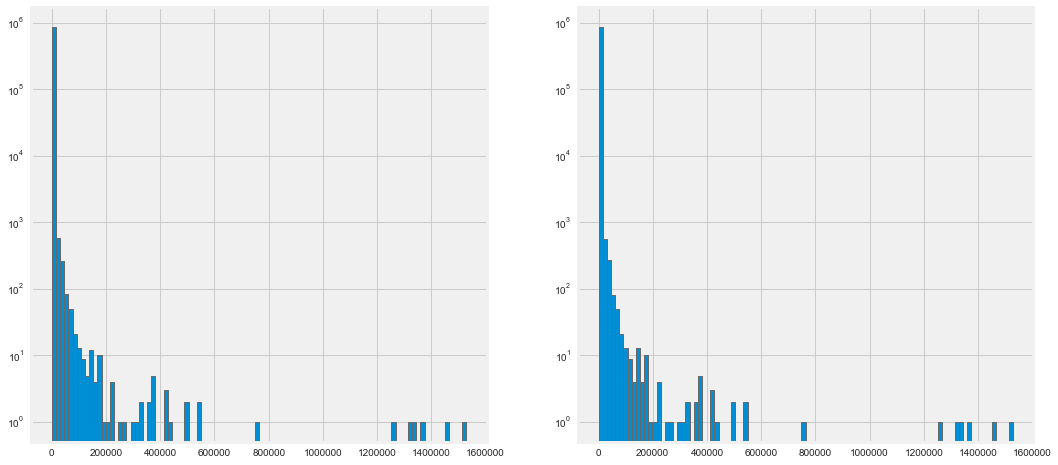

In [37]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
df.TIME_FROM_LAST_SCH_LAND.hist(bins=100)
plt.yscale('log')
plt.subplot(1, 2, 2)
df.TIME_FROM_LAST_FACT_LAND.hist(bins=100)
plt.yscale('log')

In [38]:
np.percentile(df.TIME_FROM_LAST_SCH_LAND, 99)

1790.0

1790 минут это почти 30 часов. Вопрос: сколько времени максимум борт может находиться в аэропорту? (чтобы считать остальное выбросами и удалить)

In [39]:
# считаем задежрку как разница между 
# "дата и время отправления (расчетное)" 
#                  и 
# "дата и время отправления (по расписанию)"
df['START_DELAY'] = df.BLOCK_OFF_DATE_TIME - df.SCH_START_DATE_TIME
#df['END_DELAY'] = df.BLOCK_ON_DATE_TIME - df.SCH_END_DATE_TIME
# переводим задержку в минуты
#df.END_DELAY = df.END_DELAY.apply(lambda x: x.total_seconds() // 60)
df.START_DELAY = df.START_DELAY.apply(lambda x: x.total_seconds() // 60)
df.head()

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,latitude_deg_out,longitude_deg_out,iata_code_out,iso_country_out,scheduled_service_out,type_closed_out,type_large_airport_out,type_medium_airport_out,type_small_airport_out,latitude_deg_in,longitude_deg_in,iata_code_in,iso_country_in,scheduled_service_in,type_closed_in,type_large_airport_in,type_medium_airport_in,type_small_airport_in,SCH_START_DATE_TIME_MIN,SCH_END_DATE_TIME_MIN,BLOCK_ON_DATE_TIME_MIN,SCH_TIME_IN_OUT_SVO,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,START_DELAY
477992,1642,2013-04-09,2013-04-09,100,SVO,ASF,SVO,ASF,2013-04-09 04:30:00,2013-04-09 04:40:00,2013-04-09 06:30:00,2013-04-09 06:40:00,2013-04-09 04:30:00,2013-04-09 06:50:00,2013-04-09 04:30:00,2013-04-09 06:37:00,VPBME,SVOA320SU,True,2.0,10000.0,-1.0,-8.0,1012.0,0.0,...,55.972599,37.414600,SVO,RU,1,0,1,0,0,46.283298,48.006302,ASF,RU,1,0,0,1,0,668430.0,668570.0,668560.0,2013-04-09 04:30:00,-1.0,-1.0,0.0
174333,1703,2013-04-10,2013-04-10,100,VVO,SVO,VVO,SVO,2013-04-10 03:13:00,2013-04-10 03:25:00,2013-04-10 12:30:00,2013-04-10 12:36:00,2013-04-10 03:15:00,2013-04-10 12:10:00,2013-04-10 03:15:00,2013-04-10 12:30:00,VQBPK,SVOA3KRSU,False,3.0,10000.0,-4.0,-7.0,1022.0,0.0,...,43.398998,132.147995,VVO,RU,1,0,0,1,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,669795.0,670330.0,670356.0,2013-04-10 12:10:00,-1.0,-1.0,-3.0
762850,1102,2013-04-10,2013-04-10,100,SVO,KRR,SVO,KRR,2013-04-10 08:29:00,2013-04-10 08:42:00,2013-04-10 10:47:00,2013-04-10 10:55:00,2013-04-10 08:30:00,2013-04-10 10:50:00,2013-04-10 08:30:00,2013-04-10 10:57:00,VPBUO,SVOA319SU,True,6.0,10000.0,6.0,-9.0,1024.0,0.0,...,55.972599,37.414600,SVO,RU,1,0,1,0,0,45.034698,39.170502,KRR,RU,1,0,0,1,0,670110.0,670250.0,670255.0,2013-04-10 08:30:00,-1.0,-1.0,-2.0
569652,1440,2013-04-23,2013-04-23,100,SVO,IKT,SVO,IKT,2013-04-23 14:29:00,2013-04-23 14:40:00,2013-04-23 19:35:00,2013-04-23 19:45:00,2013-04-23 14:20:00,2013-04-23 20:00:00,2013-04-23 14:20:00,2013-04-23 19:29:00,VQBBC,SVOA320SU,True,2.0,10000.0,11.0,-9.0,1018.0,0.0,...,55.972599,37.414600,SVO,RU,1,0,1,0,0,52.268002,104.389000,IKT,RU,1,0,0,1,0,689180.0,689520.0,689505.0,2013-04-23 14:20:00,-1.0,-1.0,9.0
334427,2453,2013-04-23,2013-04-23,100,CDG,SVO,CDG,SVO,2013-04-23 21:16:00,2013-04-23 21:31:00,2013-04-24 00:43:00,2013-04-24 00:49:00,2013-04-23 21:25:00,2013-04-24 01:00:00,2013-04-23 21:25:00,2013-04-24 00:14:00,VQBKS,SVOA320SU,False,2.0,10000.0,6.0,-4.0,1016.0,0.0,...,49.012798,2.550000,CDG,FR,1,0,1,0,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,689605.0,689820.0,689809.0,2013-04-24 01:00:00,-1.0,-1.0,-9.0


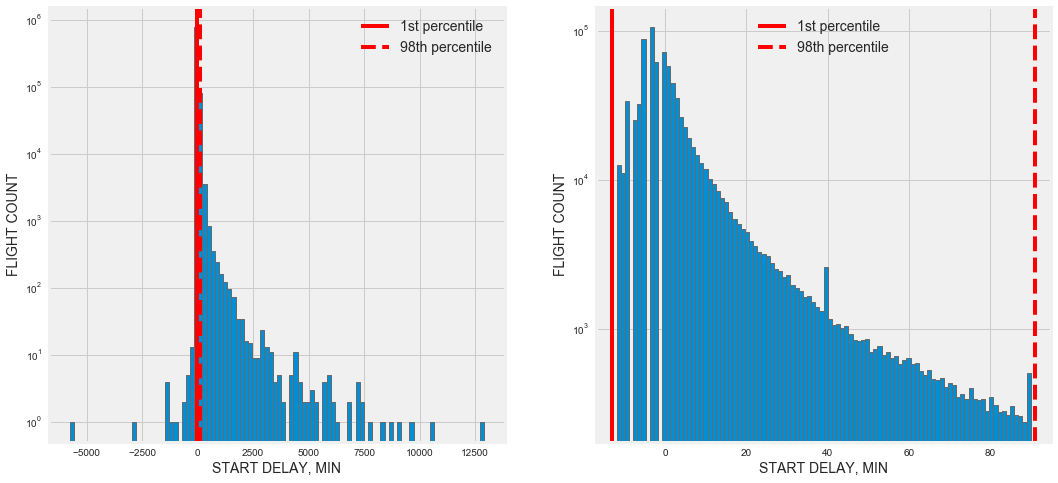

In [40]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
df.START_DELAY.hist(bins=100)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.START_DELAY, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.START_DELAY, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df.START_DELAY[(df.START_DELAY > np.percentile(df.START_DELAY, 1)) & 
                        (df.START_DELAY < np.percentile(df.START_DELAY, 98))]
plt.hist(delays, bins=100)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.START_DELAY, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.START_DELAY, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

In [41]:
np.percentile(df.START_DELAY, 1), np.percentile(df.START_DELAY, 98)

(-13.0, 91.0)

Задержка более 90 минут происходит менее чем в 2х процентах случаев, и это обычно исключительные ситуации, связанные, например, с экстра плохой погодой. Такие задержки выявляются, и особо интереса не представляют. Поэтому мы их уберём из рассмотрения

In [42]:
df = df[(df.START_DELAY > np.percentile(df.START_DELAY, 1)) & 
        (df.START_DELAY < np.percentile(df.START_DELAY, 98))]

In [43]:
df = df[(df.TIME_FROM_LAST_SCH_LAND > -1) & (df.TIME_FROM_LAST_FACT_LAND > -1)]

In [44]:
df['LATE_ARRIVAL_BEFORE'] = (df['TIME_FROM_LAST_SCH_LAND'] - df['TIME_FROM_LAST_FACT_LAND']) >= 15

In [45]:
df['LATE_ARRIVAL_BEFORE'].replace({True: 1, False: 0}, inplace=True)

In [46]:
df[['TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND', 'LATE_ARRIVAL_BEFORE']].describe()

,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,LATE_ARRIVAL_BEFORE
count,8.410130e+05,8.410130e+05,841013.000000
mean,2.424429e+02,2.364334e+02,0.188945
std,3.410761e+03,3.407769e+03,0.391465
min,0.000000e+00,0.000000e+00,0.000000
25%,6.000000e+01,6.200000e+01,0.000000
50%,9.000000e+01,8.700000e+01,0.000000
75%,1.600000e+02,1.550000e+02,0.000000
max,1.461305e+06,1.461527e+06,1.000000


Булевские переменные: задержка (больше или равна/меньше) трешхолда

In [47]:
thresholds = [5, 10, 15, 30, 60, 90]
for threshold in thresholds:
    df['START_DELAY_GREATER_' + str(threshold)] = df.START_DELAY.apply(lambda x: int(x >= threshold))
    #df['START_DELAY_LESS_' + str(threshold)] = int(df.START_DELAY < threshold)
    #df['END_DELAY_GREATER_' + str(threshold)] = df.END_DELAY >= threshold
    #df['END_DELAY_LESS_' + str(threshold)] = df.END_DELAY < threshold

Удаляем строки, которые имеют пустые значения, потому что их не так много, и они портят всё

In [48]:
#df = df.dropna()

In [49]:
check_nulls(df).head()

,Total,Percent
START_DELAY_GREATER_90,0,0.0
START_DELAY_GREATER_60,0,0.0
second_layer_height,0,0.0
second_layer_CB,0,0.0
clouds_hidden,0,0.0


In [50]:
df.head()

,FLIGHT_NUMBER,ORIGINAL_FLIGHT_DATE,FLIGHT_DATE,LEG_SEQUENCE_NUBMBER,PUB_DEPARTURE_AIRPORT_CODE,PUB_ARRIVAL_AIRPORT_CODE,DEPARTURE_AIRPORT_CODE,ARRIVAL_AIRPORT_CODE,BLOCK_OFF_DATE_TIME,TAKE_OFF_DATE_TIME,LANDING_DATE_TIME,BLOCK_ON_DATE_TIME,SCH_START_DATE_TIME,SCH_END_DATE_TIME,ESTIMATED_START_DATE_TIME,ESTIMATED_END_DATE_TIME,TAIL_NUMBER,DISPLAY_CODE,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,...,type_medium_airport_out,type_small_airport_out,latitude_deg_in,longitude_deg_in,iata_code_in,iso_country_in,scheduled_service_in,type_closed_in,type_large_airport_in,type_medium_airport_in,type_small_airport_in,SCH_START_DATE_TIME_MIN,SCH_END_DATE_TIME_MIN,BLOCK_ON_DATE_TIME_MIN,SCH_TIME_IN_OUT_SVO,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,START_DELAY,LATE_ARRIVAL_BEFORE,START_DELAY_GREATER_5,START_DELAY_GREATER_10,START_DELAY_GREATER_15,START_DELAY_GREATER_30,START_DELAY_GREATER_60,START_DELAY_GREATER_90
89,1123,2013-04-24,2013-04-24,100,AER,SVO,AER,SVO,2013-04-24 09:39:00,2013-04-24 09:49:00,2013-04-24 12:02:00,2013-04-24 12:07:00,2013-04-24 09:45:00,2013-04-24 12:00:00,2013-04-24 09:45:00,2013-04-24 12:12:00,VQBBC,SVOA320SU,False,4.0,10000.0,6.0,3.0,1005.0,6.0,...,0,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,690345.0,690480.0,690487.0,2013-04-24 12:00:00,825.0,840.0,-6.0,0,0,0,0,0,0,0
396636,2347,2013-04-24,2013-04-24,100,HAM,SVO,HAM,SVO,2013-04-24 10:44:00,2013-04-24 11:01:00,2013-04-24 13:17:00,2013-04-24 13:24:00,2013-04-24 10:20:00,2013-04-24 13:00:00,2013-04-24 10:40:00,2013-04-24 13:27:00,VPBME,SVOA320SU,False,3.0,10000.0,7.0,4.0,1005.0,6.0,...,0,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,690380.0,690540.0,690564.0,2013-04-24 13:00:00,21810.0,21820.0,24.0,0,1,1,1,0,0,0
614005,1150,2013-04-24,2013-04-24,100,SVO,GDZ,SVO,GDZ,2013-04-24 10:53:00,2013-04-24 11:07:00,2013-04-24 12:56:00,2013-04-24 13:03:00,2013-04-24 10:55:00,2013-04-24 13:15:00,2013-04-24 10:55:00,2013-04-24 13:06:00,VPBLH,SVOA32RSU,True,4.0,10000.0,7.0,4.0,1005.0,6.0,...,0,0,44.582093,38.012481,GDZ,RU,1,0,0,1,0,690415.0,690555.0,690543.0,2013-04-24 10:55:00,65.0,62.0,-3.0,0,0,0,0,0,0,0
283820,2013,2013-04-24,2013-04-24,100,PRG,SVO,PRG,SVO,2013-04-24 11:12:00,2013-04-24 11:23:00,2013-04-24 13:37:00,2013-04-24 13:43:00,2013-04-24 11:00:00,2013-04-24 13:30:00,2013-04-24 11:00:00,2013-04-24 13:44:00,VPBZS,SVOA320SU,False,2.0,10000.0,8.0,5.0,1005.0,6.0,...,0,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,690420.0,690570.0,690583.0,2013-04-24 13:30:00,50.0,45.0,12.0,0,1,1,0,0,0,0
277537,2551,2013-04-24,2013-04-24,100,AMS,SVO,AMS,SVO,2013-04-24 11:21:00,2013-04-24 11:32:00,2013-04-24 14:18:00,2013-04-24 14:24:00,2013-04-24 11:10:00,2013-04-24 14:15:00,2013-04-24 11:10:00,2013-04-24 14:28:00,VPBWP,SVOA321SU,False,2.0,10000.0,8.0,5.0,1005.0,6.0,...,0,0,55.972599,37.414600,SVO,RU,1,0,1,0,0,690430.0,690615.0,690624.0,2013-04-24 14:15:00,55.0,50.0,11.0,0,1,1,0,0,0,0


Год, месяц, день, день недели, время года (квартал), время суток

In [51]:
df['FLIGHT_YEAR'] = df.ORIGINAL_FLIGHT_DATE.apply(lambda x: x.year)
df['FLIGHT_MONTH'] = df.ORIGINAL_FLIGHT_DATE.apply(lambda x: x.month)
df['FLIGHT_DAY'] = df.ORIGINAL_FLIGHT_DATE.apply(lambda x: x.day)
df['FLIGHT_WEEKDAY'] = df.ORIGINAL_FLIGHT_DATE.apply(lambda x: x.isoweekday())
df['FLIGHT_YEAR_QUARTER'] = df.FLIGHT_MONTH.apply(lambda x: (x - 1) // 3)
df['FLIGHT_TIME_TO_MIDNIGHT'] = df.SCH_START_DATE_TIME.apply(lambda x: x.hour if x.hour <= 12 else (24 - x.hour))

Посчитаем количество бортов на момент вылета/прилёта по расписанию

In [52]:
df['TIME_IN_OUT_SVO'] = df.apply(lambda x: x.BLOCK_OFF_DATE_TIME if x.IS_FROM_SVO == True else x.BLOCK_ON_DATE_TIME, axis=1)
df['SCH_TIME_IN_OUT_SVO'] = df.apply(lambda x: x.SCH_START_DATE_TIME if x.IS_FROM_SVO == True else x.SCH_END_DATE_TIME, axis=1)

In [53]:
df.sort_values(by=['SCH_TIME_IN_OUT_SVO', 'TIME_IN_OUT_SVO'], ascending=True, inplace=True)

unique_planes = list(set(df.TAIL_NUMBER))
count_planes = list()
to_check_ind = set()
set_in = set()
set_out = set()
for row in df.itertuples():
    
    to_check_ind.add(row[0])
    
    for ind in list(to_check_ind):
        in_out = row.SCH_TIME_IN_OUT_SVO >= df.loc[ind, 'TIME_IN_OUT_SVO']
        if df.loc[ind, 'IS_FROM_SVO']:
            if in_out:
                to_check_ind.discard(ind)
                set_out.add(df.loc[ind, 'TAIL_NUMBER'])
                set_in.discard(df.loc[ind, 'TAIL_NUMBER'])
        else:
            if in_out:
                to_check_ind.discard(ind)
                set_in.add(df.loc[ind, 'TAIL_NUMBER'])
                set_out.discard(df.loc[ind, 'TAIL_NUMBER'])
                
    count_planes.append(len(set_in))

df['COUNT_PLANES_ON_SCH_TIME'] = count_planes

Посмотрим на количество рейсов в месяц

In [54]:
gr = df[['FLIGHT_YEAR', 'FLIGHT_MONTH', 'COUNT_PLANES_ON_SCH_TIME']].groupby(['FLIGHT_YEAR', 'FLIGHT_MONTH']).count().reset_index()
gr.head()

,FLIGHT_YEAR,FLIGHT_MONTH,COUNT_PLANES_ON_SCH_TIME
0,2013,4,2838
1,2013,5,8865
2,2013,6,458
3,2013,7,4720
4,2013,8,13486


In [55]:
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.FLIGHT_YEAR, x.FLIGHT_MONTH, 1), axis=1)

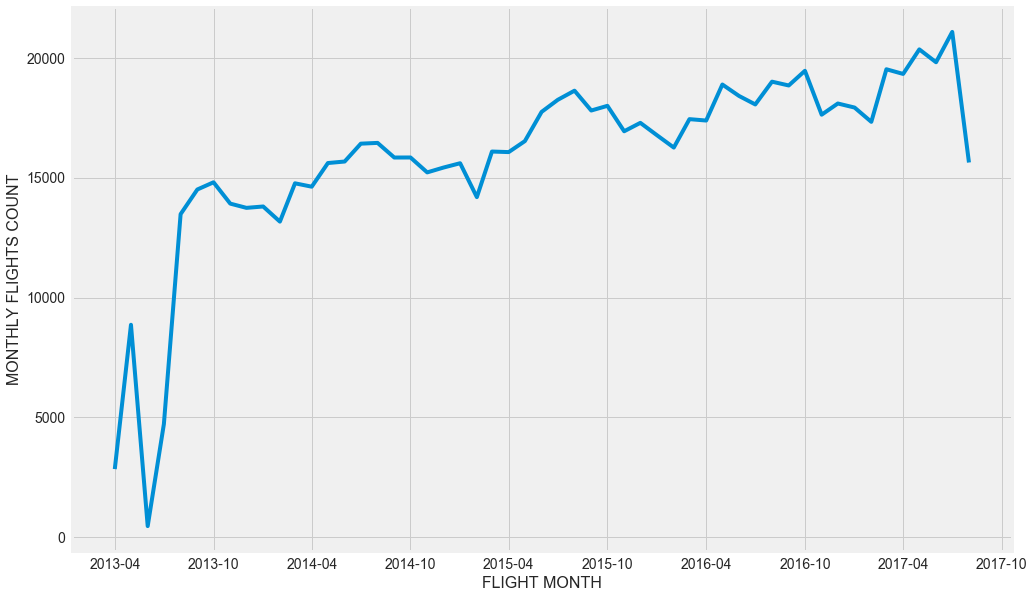

In [56]:
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.COUNT_PLANES_ON_SCH_TIME)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

Имеет смысл рассматривать период времени с августа 2013 по июль 2017

In [57]:
start_date = datetime.datetime(2013, 8, 1)
end_date = datetime.datetime(2017, 8, 1)
df = df[df.SCH_START_DATE_TIME >= start_date]
df = df[df.SCH_START_DATE_TIME <= end_date]

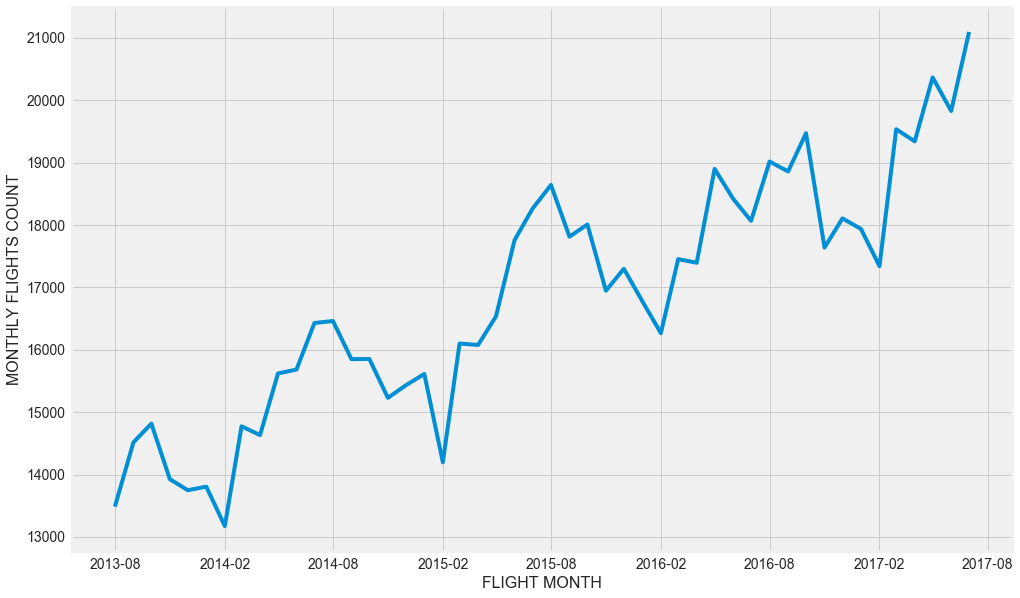

In [58]:
gr = df[['FLIGHT_YEAR', 'FLIGHT_MONTH', 'COUNT_PLANES_ON_SCH_TIME']].groupby(['FLIGHT_YEAR', 'FLIGHT_MONTH']).count().reset_index()
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.FLIGHT_YEAR, x.FLIGHT_MONTH, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.COUNT_PLANES_ON_SCH_TIME)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

In [59]:
df.shape

(808490, 120)

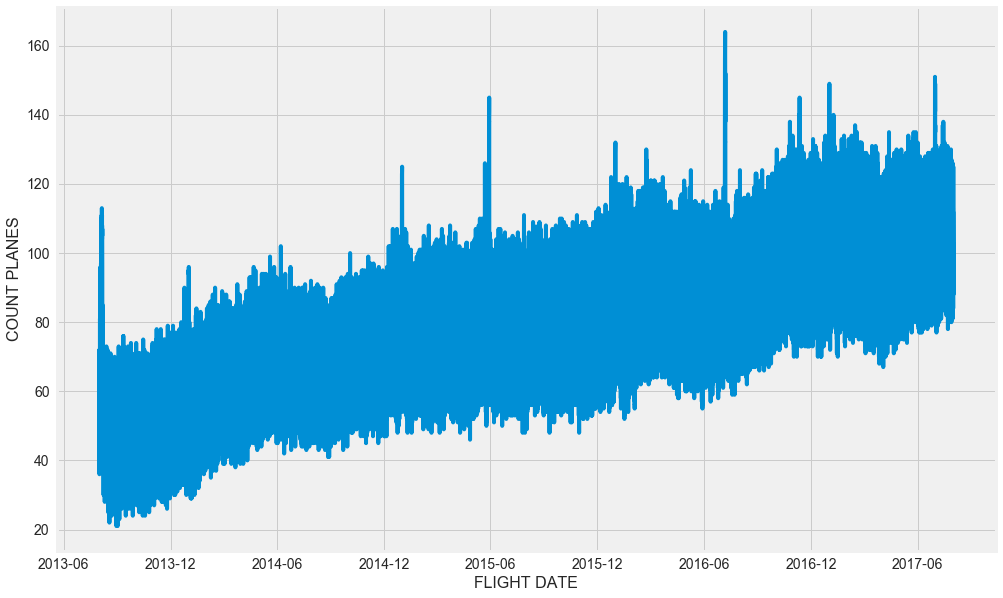

In [60]:
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(df.SCH_TIME_IN_OUT_SVO, df.COUNT_PLANES_ON_SCH_TIME)
plt.xlabel('FLIGHT DATE', fontsize=16)
plt.ylabel('COUNT PLANES', fontsize=16)
plt.grid('on')


Посмотрим на количество бортов в аэропорту во времени тоже поближе (меньше срез времени).

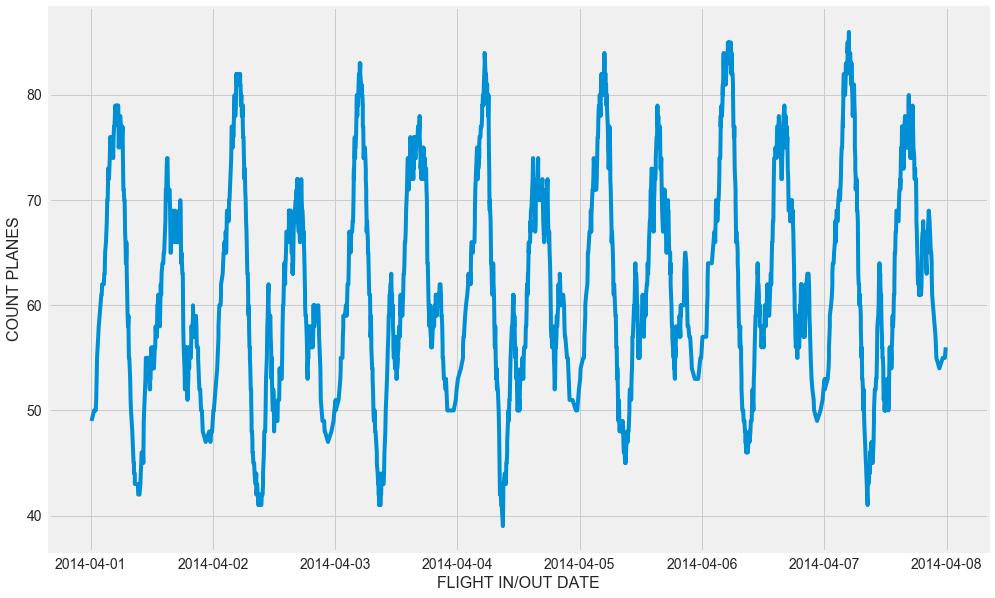

In [61]:
temp1 = df[df.SCH_TIME_IN_OUT_SVO >= datetime.datetime(2014, 4, 1)]
temp1 = temp1[temp1.SCH_TIME_IN_OUT_SVO < datetime.datetime(2014, 4, 8)]

plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(temp1.SCH_TIME_IN_OUT_SVO, temp1.COUNT_PLANES_ON_SCH_TIME)
plt.xlabel('FLIGHT IN/OUT DATE', fontsize=16)
plt.ylabel('COUNT PLANES', fontsize=16)
plt.grid('on')

Очевидно, что есть суточный тренд по количеству самолётов, находящихся в аэропорту.

Посмотрим на среднюю задержку каждый месяц для всех годов

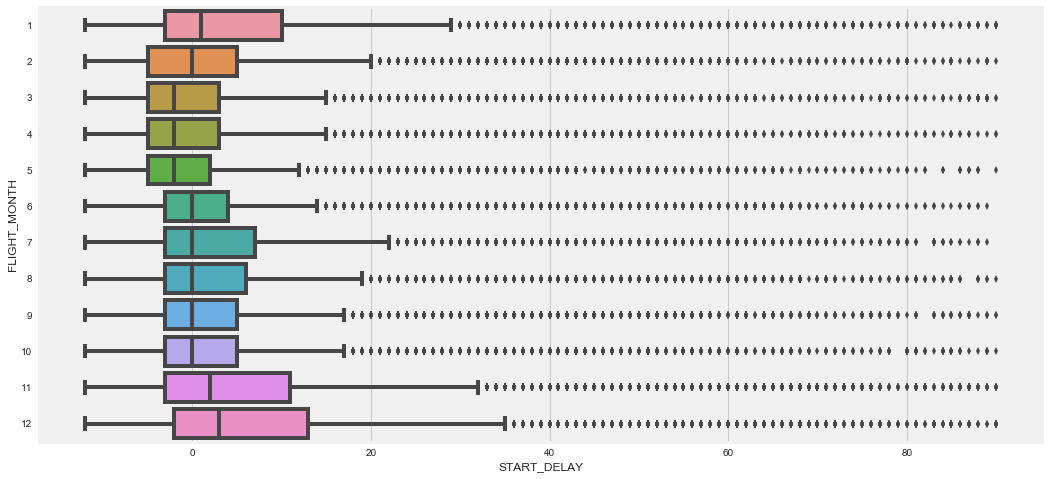

In [64]:
temp = df[df.FLIGHT_YEAR == 2016]
plt.figure(figsize=(16, 8))
sns.boxplot(y="FLIGHT_MONTH", x="START_DELAY", data=temp, orient='h')

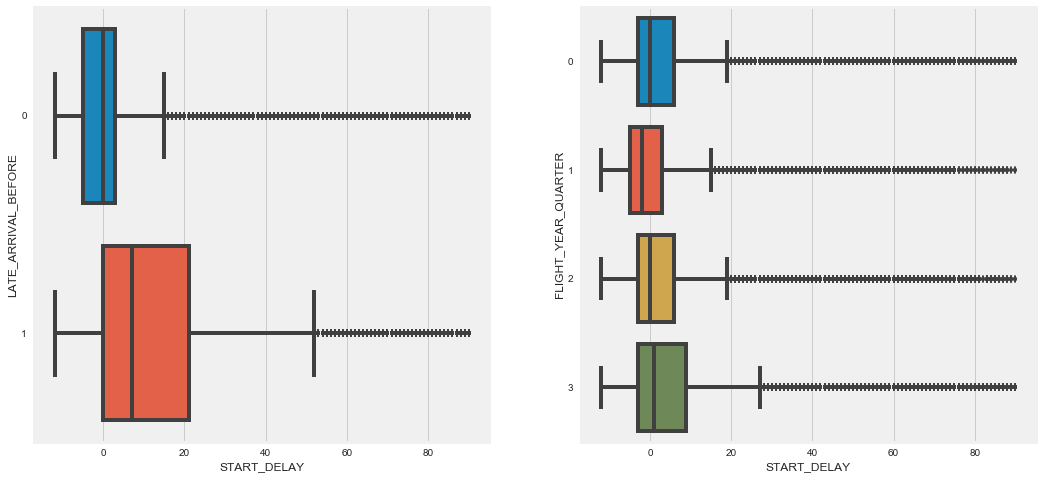

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y="LATE_ARRIVAL_BEFORE", x="START_DELAY", data=temp, orient='h')
plt.subplot(1, 2, 2)
sns.boxplot(y="FLIGHT_YEAR_QUARTER", x="START_DELAY",data=temp, orient='h')

In [66]:
df.sort_values(by='SCH_TIME_IN_OUT_SVO', ascending=True, inplace=True)

In [114]:
def ratio_cumsum_attribute(df, arg_cols, datecol, bool_col, timedelta=datetime.timedelta(days=7), inplace=True):
#     if sort != '':
#         new_col_name = '_'.join(arg_cols)+'_'+ bool_col +'_ratio_sortby_' + sort
#         df.sort_values(by=sort, ascending=ascending, inplace=True)
#     else:
    new_col_name = '_'.join(arg_cols)+'_'+ bool_col + '_ratio'
    temp = df[arg_cols + [datecol, bool_col]]    
    dict_all = dict()
    newcol = list()
    arg_cols_ind = list(range(1, len(arg_cols)+1))
    datecol_ind = len(arg_cols) + 1
    bool_col_ind = datecol_ind + 1
    
    for row in temp.itertuples():
        key_list = list()
        for colind in arg_cols_ind:
            key_list.append(str(row[colind]))
        key = '_'.join(key_list)
        
        if key not in dict_all:
            val = 0
            dict_all[key] = {0: [], 1: []}
        else:
            for bi in [0, 1]:
                pop_keys = 0
                for i in range(len(dict_all[key][bi])):
                    if row[datecol_ind] - dict_all[key][bi][i] > timedelta:
                        pop_keys += 1
                    else:
                        break
                dict_all[key][bi] = dict_all[key][bi][pop_keys:]
            if (len(dict_all[key][0]) == 0) and (len(dict_all[key][1]) == 0):
                val = 0
            else:
                val = len(dict_all[key][1]) / (len(dict_all[key][1] + dict_all[key][0]))
                
        dict_all[key][row[bool_col_ind]].append(row[datecol_ind])
        newcol.append(val)
        
    if inplace:
        df[new_col_name] = newcol
        
    return dict_all, newcol

In [115]:
#df['PUB_DEPARTURE_ARRIVAL'] = df.apply(lambda x: x.PUB_DEPARTURE_AIRPORT_CODE + '-' + x.PUB_ARRIVAL_AIRPORT_CODE)

In [116]:
#df['PUB_DEPARTURE_AIRPORT_CODE'] = flight_leg_exp['PUB_DEPARTURE_AIRPORT_CODE']
#df['PUB_ARRIVAL_AIRPORT_CODE'] = flight_leg_exp['PUB_ARRIVAL_AIRPORT_CODE']

In [122]:
thresholds = [5, 10, 15, 30, 60, 90]
#thresholds=[15]
from time import time
vals = {0: ['TAIL_NUMBER'],
        1: ['DISPLAY_CODE'], 
        2: ['LEG_SEQUENCE_NUBMBER'],
        3: ['PUB_DEPARTURE_AIRPORT_CODE', 'PUB_ARRIVAL_AIRPORT_CODE'],
        4: ['iso_country_in', 'iso_country_out'],
        5: ['scheduled_service_in', 'scheduled_service_out'],
        6: ['type_closed_in'],
        7: ['type_large_airport_in'],
        8: ['type_medium_airport_in'],
        9: ['type_small_airport_in']
       }
start_total = time()
for threshold in thresholds:
    print('threshold: %d minutes' % threshold)
    for val in vals.keys():
        start = time()
        print(vals[val])
        ratio_cumsum_attribute(df, vals[val], 'BLOCK_OFF_DATE_TIME', 'START_DELAY_GREATER_' + str(threshold))
        print('time elapsed %3.2f min' % ((time() - start) / 60))
    print()
print('total execution time %3.2f minutes' % ((time() - start_total) / 60))

threshold: 5 minutes
['TAIL_NUMBER']
time elapsed 1.00 min
['DISPLAY_CODE']
time elapsed 1.10 min
['LEG_SEQUENCE_NUBMBER']
time elapsed 1.59 min
['PUB_DEPARTURE_AIRPORT_CODE', 'PUB_ARRIVAL_AIRPORT_CODE']
time elapsed 1.00 min
['iso_country_in', 'iso_country_out']
time elapsed 1.14 min
['scheduled_service_in', 'scheduled_service_out']
time elapsed 1.62 min
['type_closed_in']
time elapsed 1.59 min
['type_large_airport_in']
time elapsed 1.53 min
['type_medium_airport_in']
time elapsed 1.57 min
['type_small_airport_in']
time elapsed 1.59 min
threshold: 10 minutes
['TAIL_NUMBER']
time elapsed 0.98 min
['DISPLAY_CODE']
time elapsed 1.10 min
['LEG_SEQUENCE_NUBMBER']
time elapsed 1.59 min
['PUB_DEPARTURE_AIRPORT_CODE', 'PUB_ARRIVAL_AIRPORT_CODE']
time elapsed 0.97 min
['iso_country_in', 'iso_country_out']
time elapsed 1.11 min
['scheduled_service_in', 'scheduled_service_out']
time elapsed 1.64 min
['type_closed_in']
time elapsed 1.58 min
['type_large_airport_in']
time elapsed 1.46 min
['type_m

In [123]:
df[['TAIL_NUMBER_START_DELAY_GREATER_15_ratio',
       #'DISPLAY_CODE_START_DELAY_GREATER_15_ratio',
       #'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_15_ratio',
       #'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_15_ratio', 
    'TAIL_NUMBER', 'START_DELAY', 'BLOCK_OFF_DATE_TIME'
       #'TAIL_NUMBER_END_DELAY_GREATER_15_ratio',
       #'DISPLAY_CODE_END_DELAY_GREATER_15_ratio',
       #'LEG_SEQUENCE_NUBMBER_END_DELAY_GREATER_15_ratio',
       #'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_END_DELAY_GREATER_15_ratio'
   ]][df['TAIL_NUMBER'] == 'VPBME'].head(20)

,TAIL_NUMBER_START_DELAY_GREATER_15_ratio,TAIL_NUMBER,START_DELAY,BLOCK_OFF_DATE_TIME
258423,0.000000,VPBME,2.0,2013-08-01 01:12:00
759886,0.000000,VPBME,28.0,2013-08-01 07:23:00
113300,0.500000,VPBME,27.0,2013-08-01 10:52:00
573759,0.666667,VPBME,7.0,2013-08-01 15:22:00
52357,0.500000,VPBME,-3.0,2013-08-01 17:32:00
455318,0.400000,VPBME,-3.0,2013-08-03 06:32:00
455319,0.333333,VPBME,-3.0,2013-08-03 06:32:00
10108,0.285714,VPBME,-9.0,2013-08-03 10:27:00
10109,0.250000,VPBME,-9.0,2013-08-03 10:27:00
628632,0.222222,VPBME,2.0,2013-08-03 14:37:00


In [125]:
df.drop(['BLOCK_OFF_DATE_TIME',
        'TAKE_OFF_DATE_TIME',
        'LANDING_DATE_TIME',
        'BLOCK_ON_DATE_TIME',
        'SCH_START_DATE_TIME',
        'SCH_END_DATE_TIME',
        'ESTIMATED_START_DATE_TIME',
        'ESTIMATED_END_DATE_TIME',
        'ORIGINAL_FLIGHT_DATE',
        'PUB_DEPARTURE_AIRPORT_CODE',
        'PUB_ARRIVAL_AIRPORT_CODE',
        'DEPARTURE_AIRPORT_CODE',
        'ARRIVAL_AIRPORT_CODE',
        #'FLIGHT_NUMBER',
        #'START_DELAY_LESS_15', 
        #'END_DELAY_GREATER_15', 
        #'END_DELAY_LESS_15', 
        'TAIL_NUMBER', 
        'DISPLAY_CODE',
        'TIME_IN_OUT_SVO', 
        'SCH_TIME_IN_OUT_SVO', 
         #'START_DELAY', 'END_DELAY',
        'SCH_START_DATE_TIME_MIN', 'SCH_END_DATE_TIME_MIN',
         'BLOCK_ON_DATE_TIME_MIN', 'FLIGHT_NUMBER',
         'FLIGHT_DATE',
         'iata_code_out',
       'iso_country_out', 'latitude_deg_in', 'longitude_deg_in',
       'iata_code_in', 'iso_country_in',
        ], axis=1, inplace=True)

In [126]:
df.replace({True: 1, False: 0}, inplace=True)
df.to_csv('new_df_utc.csv')

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import warnings
import xgboost
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
df = pd.read_csv('new_df_utc.csv', index_col=0)

In [3]:
df.head()

,LEG_SEQUENCE_NUBMBER,IS_FROM_SVO,wind_speed_mps,vis,temp,dewpt,press,first_layer_coverage,first_layer_height,first_layer_CB,...,type_small_airport_in_START_DELAY_GREATER_60_ratio,DISPLAY_CODE_START_DELAY_GREATER_90_ratio,LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_90_ratio,PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_90_ratio,iso_country_in_iso_country_out_START_DELAY_GREATER_90_ratio,scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_90_ratio,type_closed_in_START_DELAY_GREATER_90_ratio,type_large_airport_in_START_DELAY_GREATER_90_ratio,type_medium_airport_in_START_DELAY_GREATER_90_ratio,type_small_airport_in_START_DELAY_GREATER_90_ratio
794398,100,1,2.0,3000.0,15.0,15.0,1008.0,8.0,91.439997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638325,100,1,3.0,4300.0,16.0,15.0,1008.0,3.0,121.919996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
849735,100,1,3.0,4300.0,16.0,15.0,1008.0,3.0,121.919996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497164,100,1,3.0,4300.0,16.0,15.0,1008.0,3.0,121.919996,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133234,100,0,3.0,5000.0,15.0,14.0,1008.0,6.0,457.199985,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df1 = df[df.IS_FROM_SVO == True]

Remove very bad correlated features (almost all weather)

In [5]:
df1.drop([ 'wind_speed_mps',  'first_layer_coverage', 'first_layer_height',
       'first_layer_CB', 'first_layer_TCU', 'second_layer_coverage',
       'second_layer_height', 'second_layer_CB', 'clouds_hidden',
       'vertical_visibility', 'snow and rain', 'freezing rain', 'snow showers',
       'heavy snow', 'light snow pellets showers', 'light rain', 'fog',
       'light snow and snow pellets showers', 'light snow and rain showers',
       'snow and snow pellets showers', 'light snow',
       'light rain and snow showers', 'light snow grains', 'patches of fog',
       'light snow showers', 'rain', 'mist', 'light freezing rain and snow',
       'light freezing rain', 'light snow and rain',
       'light thunderstorm with rain and hail', 'thunderstorm with rain',
       'snow', 'light ice pellets', 'haze', 'light freezing drizzle',
       'freezing fog', 'low drifting snow', 'ice crystals', 'ice pellets',
       'snow pellets showers', 'heavy snow showers',
       'light rain and snow pellets showers', 'thunderstorm',
       'freezing rain and snow', 'drizzle', 'smoke', 'light rain showers',
       'heavy thunderstorm with rain and hail', 'light drizzle',
       'light thunderstorm with snow', 'light rain and snow',
       'light thunderstorm with rain', 'blowing snow', 'snow and snow pellets',
       'shallow fog', 'nearby thunderstorm', 'latitude_deg_out',
       'longitude_deg_out', 'scheduled_service_out', 'type_closed_out',
       'type_large_airport_out', 'type_medium_airport_out',
       'type_small_airport_out', 'scheduled_service_in', 'type_closed_in',
       'type_large_airport_in', 'type_medium_airport_in',
       'type_small_airport_in', ], axis=1, inplace=True)

In [6]:
df_regr = df1.copy()
df1.drop(['START_DELAY', 'START_DELAY_GREATER_10',
       'START_DELAY_GREATER_60', 'START_DELAY_GREATER_30', 'START_DELAY_GREATER_90',
       'START_DELAY_GREATER_15', 
        'TAIL_NUMBER_START_DELAY_GREATER_60_ratio',
       'TAIL_NUMBER_START_DELAY_GREATER_10_ratio',
        'TAIL_NUMBER_START_DELAY_GREATER_30_ratio',
       'TAIL_NUMBER_START_DELAY_GREATER_90_ratio',
       'TAIL_NUMBER_START_DELAY_GREATER_15_ratio',
          'DISPLAY_CODE_START_DELAY_GREATER_10_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_10_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_10_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_10_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_10_ratio',
       'type_closed_in_START_DELAY_GREATER_10_ratio',
       'type_large_airport_in_START_DELAY_GREATER_10_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_10_ratio',
       'type_small_airport_in_START_DELAY_GREATER_10_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_60_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_60_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_60_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_60_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_60_ratio',
       'type_closed_in_START_DELAY_GREATER_60_ratio',
       'type_large_airport_in_START_DELAY_GREATER_60_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_60_ratio',
       'type_small_airport_in_START_DELAY_GREATER_60_ratio',
        'DISPLAY_CODE_START_DELAY_GREATER_30_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_30_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_30_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_30_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_30_ratio',
       'type_closed_in_START_DELAY_GREATER_30_ratio',
       'type_large_airport_in_START_DELAY_GREATER_30_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_30_ratio',
       'type_small_airport_in_START_DELAY_GREATER_30_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_90_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_90_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_90_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_90_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_90_ratio',
       'type_closed_in_START_DELAY_GREATER_90_ratio',
       'type_large_airport_in_START_DELAY_GREATER_90_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_90_ratio',
       'type_small_airport_in_START_DELAY_GREATER_90_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_15_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_15_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_15_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_15_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_15_ratio',
       'type_closed_in_START_DELAY_GREATER_15_ratio',
       'type_large_airport_in_START_DELAY_GREATER_15_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_15_ratio',
       'type_small_airport_in_START_DELAY_GREATER_15_ratio'
], axis=1, inplace=True)
#df_regr.drop(['START_DELAY_GREATER_15'], axis=1, inplace=True)

In [7]:
df1.columns

Index(['LEG_SEQUENCE_NUBMBER', 'IS_FROM_SVO', 'vis', 'temp', 'dewpt', 'press',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'START_DELAY_GREATER_5', 'FLIGHT_YEAR',
       'FLIGHT_MONTH', 'FLIGHT_DAY', 'FLIGHT_WEEKDAY', 'FLIGHT_YEAR_QUARTER',
       'FLIGHT_TIME_TO_MIDNIGHT', 'COUNT_PLANES_ON_SCH_TIME',
       'TAIL_NUMBER_START_DELAY_GREATER_5_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_5_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_5_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_5_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_5_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_5_ratio',
       'type_closed_in_START_DELAY_GREATER_5_ratio',
       'type_large_airport_in_START_DELAY_GREATER_5_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_5_ratio',
       'type_small_airport_in_START_DELAY_GREATER_5_ratio'],
      dtype='o

In [8]:
def train_test_split(df, targetcol, train_split=0.8):
    df1 = df.copy().reset_index()
    df1.drop(labels='index', axis=1, inplace=True)
    #print(df.shape)
    #print(df1.shape)
    target = df1[targetcol]
    #print(target.shape)
    df1.drop(labels=targetcol, axis=1, inplace=True)
    
    train_size = int(df1.shape[0] * 0.8)
    x_train = df1.loc[:train_size, :]
    y_train = target[:train_size+1]
    x_test = df1.loc[train_size:, :]
    y_test = target[train_size:]
    
    return x_train, y_train, x_test, y_test, x_train.columns

In [9]:
X_train, y_train, X_test, y_test, _ = train_test_split(df1, 'START_DELAY_GREATER_5')
X_train.shape

(328675, 26)

In [10]:
y_train.shape

(328675,)

In [11]:
#df1 = df[df.IS_FROM_SVO == True]
df2 = df1.drop(['IS_FROM_SVO'], axis=1)

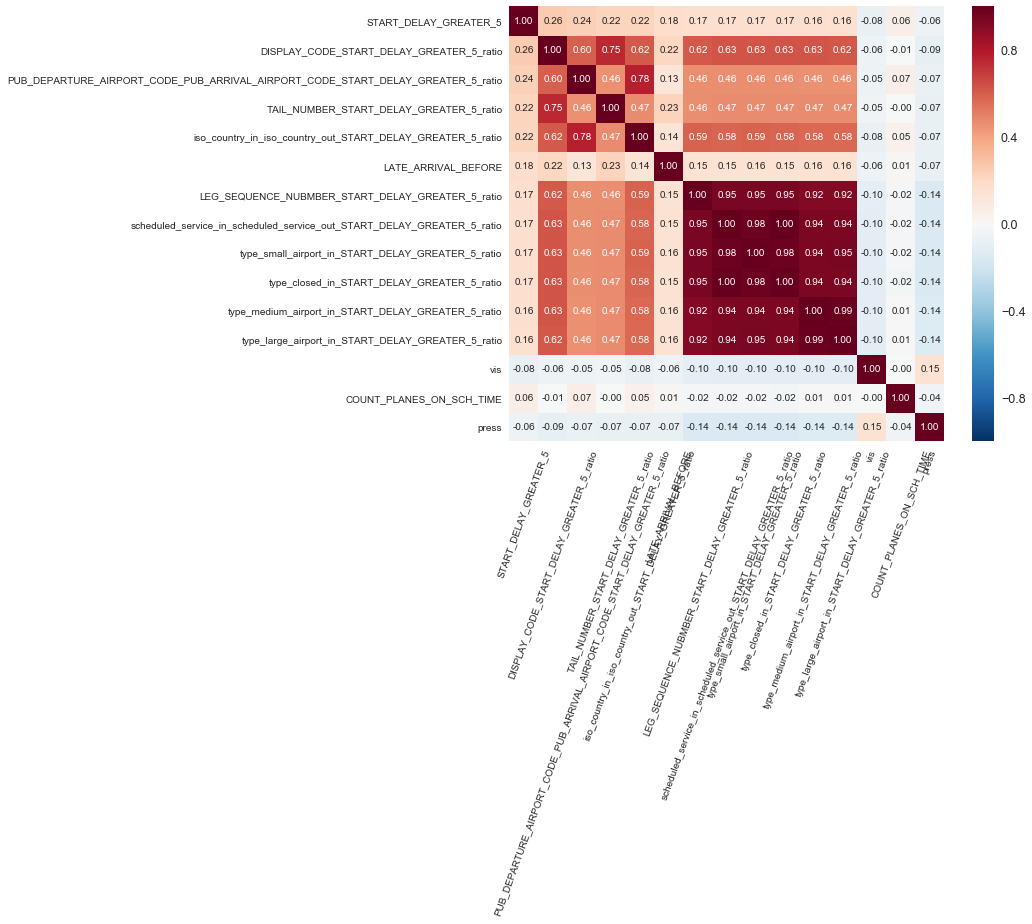

In [12]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df2.corr()
cols = corr.apply(lambda s: s.abs()).nlargest(15, 'START_DELAY_GREATER_5').index
cm = np.corrcoef(df2[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.xticks(rotation=70)
plt.show()

In [13]:
y_train.value_counts()

0    253744
1     74931
Name: START_DELAY_GREATER_5, dtype: int64

In [14]:
y_test.value_counts()

0    57360
1    24809
Name: START_DELAY_GREATER_5, dtype: int64

In [15]:
def all_classifier(df, target_col, n_components=15, to_scale=False, to_select=False, clf=None, train_split=0.8):
    x_train, y_train, x_test, y_test, _ = train_test_split(df, target_col, train_split=train_split)
    
    #scale data
    if to_scale:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    # choose components
    if to_select:
        pca=PCA(n_components=n_components)
        pca.fit(x_train)
        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
    
    # classification
    start = time()
    clf.fit(x_train, y_train)
    print('classifier training time: %3.2f minutes' % ((time() - start) / 60))
    y_pred = clf.predict(x_test)
    
    # metrics
    print('f1 score: %1.3f' % f1_score(y_test, y_pred))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    

#### Random Forest predictor

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [17]:
from time import time
est = RandomForestClassifier(n_estimators = 100, 
                             max_depth = 3,
                             n_jobs=-1, 
                             class_weight='balanced')
start = time()
est.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

classifier training time: 0.23 minutes


In [18]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
y_pred = est.predict(X_test)

print(f1_score(y_test, y_pred))

0.5449162838111463


In [19]:
confusion_matrix(y_test, y_pred)

array([[30069, 27291],
       [ 5298, 19511]], dtype=int64)

In [20]:
df1_delays = df.START_DELAY[df.IS_FROM_SVO == True]
train_size = int(df1.shape[0] * 0.8)
y_delays = df1_delays[train_size:]

In [21]:
t = (y_test == y_pred)
f = (y_test != y_pred)

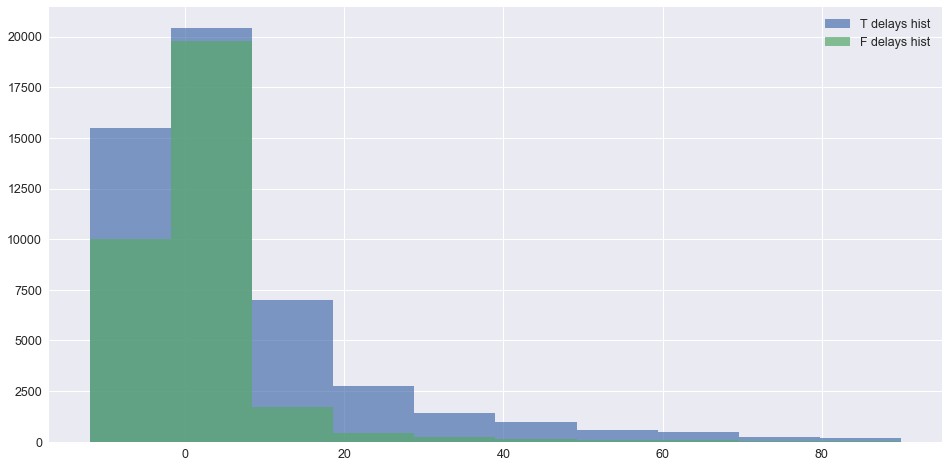

In [22]:
plt.figure(figsize=(16, 8))
tp_hist = plt.hist(y_delays[t.values], alpha=0.7, label='T delays hist')
fp_hist = plt.hist(y_delays[f.values], alpha=0.7, label='F delays hist')
plt.legend()

In [25]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [26]:
df1['YEAR_MONTH'] = df1.apply(lambda x: str(int(x.FLIGHT_YEAR)) + '_' + str(int(x.FLIGHT_MONTH)), axis=1)
year_month = np.unique(df1['YEAR_MONTH'])
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = RandomForestClassifier(n_estimators = 100, 
                                 max_depth = 3,
                                 n_jobs=-1, 
                                 class_weight='balanced')
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.01 minutes
f1 score: 0.325
confusion matrix:
[[1011  113]
 [ 282   95]]

2013_11
classifier training time: 0.00 minutes
f1 score: 0.578
confusion matrix:
[[418 448]
 [145 406]]

2013_12
classifier training time: 0.00 minutes
f1 score: 0.502
confusion matrix:
[[601 384]
 [153 271]]

2013_8
classifier training time: 0.01 minutes
f1 score: 0.386
confusion matrix:
[[759 146]
 [313 144]]

2013_9
classifier training time: 0.00 minutes
f1 score: 0.579
confusion matrix:
[[363 494]
 [165 454]]

2014_1
classifier training time: 0.00 minutes
f1 score: 0.470
confusion matrix:
[[747 225]
 [245 208]]

2014_10
classifier training time: 0.00 minutes
f1 score: 0.295
confusion matrix:
[[981 382]
 [140 109]]

2014_11
classifier training time: 0.01 minutes
f1 score: 0.316
confusion matrix:
[[1167  158]
 [ 158   73]]

2014_12
classifier training time: 0.01 minutes
f1 score: 0.514
confusion matrix:
[[  35 1001]
 [   7  533]]

2014_2
classifier training time: 0.00 minutes


#### Try SVC

In [27]:
df1.columns

Index(['LEG_SEQUENCE_NUBMBER', 'IS_FROM_SVO', 'vis', 'temp', 'dewpt', 'press',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'START_DELAY_GREATER_5', 'FLIGHT_YEAR',
       'FLIGHT_MONTH', 'FLIGHT_DAY', 'FLIGHT_WEEKDAY', 'FLIGHT_YEAR_QUARTER',
       'FLIGHT_TIME_TO_MIDNIGHT', 'COUNT_PLANES_ON_SCH_TIME',
       'TAIL_NUMBER_START_DELAY_GREATER_5_ratio',
       'DISPLAY_CODE_START_DELAY_GREATER_5_ratio',
       'LEG_SEQUENCE_NUBMBER_START_DELAY_GREATER_5_ratio',
       'PUB_DEPARTURE_AIRPORT_CODE_PUB_ARRIVAL_AIRPORT_CODE_START_DELAY_GREATER_5_ratio',
       'iso_country_in_iso_country_out_START_DELAY_GREATER_5_ratio',
       'scheduled_service_in_scheduled_service_out_START_DELAY_GREATER_5_ratio',
       'type_closed_in_START_DELAY_GREATER_5_ratio',
       'type_large_airport_in_START_DELAY_GREATER_5_ratio',
       'type_medium_airport_in_START_DELAY_GREATER_5_ratio',
       'type_small_airport_in_START_DELAY_GREATER_5_ratio', 'YEAR_MONTH'],


In [28]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from time import time

In [29]:
#df1 = df1[df.FLIGHT_YEAR == 2016]
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = SVC(kernel='rbf', class_weight='balanced')
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.03 minutes
f1 score: 0.335
confusion matrix:
[[1004  120]
 [ 277  100]]

2013_11
classifier training time: 0.02 minutes
f1 score: 0.556
confusion matrix:
[[570 296]
 [225 326]]

2013_12
classifier training time: 0.02 minutes
f1 score: 0.499
confusion matrix:
[[694 291]
 [186 238]]

2013_8
classifier training time: 0.02 minutes
f1 score: 0.477
confusion matrix:
[[724 181]
 [257 200]]

2013_9
classifier training time: 0.03 minutes
f1 score: 0.570
confusion matrix:
[[565 292]
 [256 363]]

2014_1
classifier training time: 0.02 minutes
f1 score: 0.398
confusion matrix:
[[845 127]
 [309 144]]

2014_10
classifier training time: 0.03 minutes
f1 score: 0.282
confusion matrix:
[[1142  221]
 [ 172   77]]

2014_11
classifier training time: 0.03 minutes
f1 score: 0.228
confusion matrix:
[[1261   64]
 [ 193   38]]

2014_12
classifier training time: 0.03 minutes
f1 score: 0.476
confusion matrix:
[[903 133]
 [330 210]]

2014_2
classifier training time: 0.02 minutes


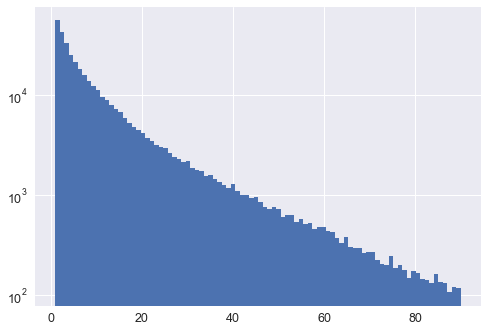

In [30]:
plt.hist(df['START_DELAY'][df.START_DELAY > 0], bins=90)
plt.yscale('log')

#### Try XGBoost

In [31]:
from time import time

start = time()
model = xgboost.XGBClassifier(n_estimators = 100, max_depth = 4)
model.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

classifier training time: 0.35 minutes


In [32]:
y_pred = est.predict(X_test)

print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5449162838111463
[[30069 27291]
 [ 5298 19511]]


In [33]:
y_pred = est.predict(X_train)

print(f1_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0.48172202020647914
[[191097  62647]
 [ 31280  43651]]


In [34]:
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = xgboost.XGBClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.01 minutes
f1 score: 0.139
confusion matrix:
[[1086   38]
 [ 346   31]]

2013_11
classifier training time: 0.01 minutes
f1 score: 0.130
confusion matrix:
[[843  23]
 [511  40]]

2013_12
classifier training time: 0.01 minutes
f1 score: 0.503
confusion matrix:
[[602 383]
 [153 271]]

2013_8
classifier training time: 0.01 minutes
f1 score: 0.291
confusion matrix:
[[810  95]
 [363  94]]

2013_9
classifier training time: 0.01 minutes
f1 score: 0.404
confusion matrix:
[[706 151]
 [424 195]]

2014_1
classifier training time: 0.00 minutes
f1 score: 0.318
confusion matrix:
[[881  91]
 [350 103]]

2014_10
classifier training time: 0.01 minutes
f1 score: 0.147
confusion matrix:
[[1323   40]
 [ 226   23]]

2014_11
classifier training time: 0.01 minutes
f1 score: 0.058
confusion matrix:
[[1320    5]
 [ 224    7]]

2014_12
classifier training time: 0.01 minutes
f1 score: 0.449
confusion matrix:
[[650 386]
 [272 268]]

2014_2
classifier training time: 0.01 minutes


**Gradient Boosting classifier**

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

start = time()
model = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
model.fit(X_train, y_train)
print('classifier training time: %3.2f minutes' % ((time() - start) / 60))

classifier training time: 1.50 minutes


In [36]:
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5300603702040613
[[52707  4653]
 [14185 10624]]


In [37]:
y_pred = model.predict(X_train)

print(f1_score(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

0.4191222991238329
[[246218   7526]
 [ 53070  21861]]


In [38]:
#df1['YEAR_MONTH'] = df1.apply(lambda x: str(int(x.FLIGHT_YEAR)) + '_' + str(int(x.FLIGHT_MONTH)), axis=1)
year_month = np.unique(df1['YEAR_MONTH'])
for ym in year_month:
    print(ym)
    df2 = df1[df1.YEAR_MONTH == ym]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013_10
classifier training time: 0.02 minutes
f1 score: 0.163
confusion matrix:
[[1018  106]
 [ 334   43]]

2013_11
classifier training time: 0.02 minutes
f1 score: 0.516
confusion matrix:
[[468 398]
 [221 330]]

2013_12
classifier training time: 0.02 minutes
f1 score: 0.499
confusion matrix:
[[675 310]
 [180 244]]

2013_8
classifier training time: 0.02 minutes
f1 score: 0.347
confusion matrix:
[[791 114]
 [337 120]]

2013_9
classifier training time: 0.02 minutes
f1 score: 0.442
confusion matrix:
[[636 221]
 [381 238]]

2014_1
classifier training time: 0.02 minutes
f1 score: 0.357
confusion matrix:
[[836 136]
 [325 128]]

2014_10
classifier training time: 0.02 minutes
f1 score: 0.208
confusion matrix:
[[1285   78]
 [ 211   38]]

2014_11
classifier training time: 0.02 minutes
f1 score: 0.201
confusion matrix:
[[1242   83]
 [ 196   35]]

2014_12
classifier training time: 0.02 minutes
f1 score: 0.468
confusion matrix:
[[584 452]
 [237 303]]

2014_2
classifier training time: 0.02 minutes


In [41]:
year = np.unique(df1['FLIGHT_YEAR'])
for y in year:
    print(y)
    df2 = df1[df1.FLIGHT_YEAR == y]
    df2.drop('YEAR_MONTH', axis=1, inplace=True)
    clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 4)
    all_classifier(df2, target_col='START_DELAY_GREATER_5', to_scale=True, to_select=True, clf=clf)
    print()

2013
classifier training time: 0.11 minutes
f1 score: 0.371
confusion matrix:
[[3710  622]
 [2046  786]]

2014
classifier training time: 0.36 minutes
f1 score: 0.288
confusion matrix:
[[13920   968]
 [ 2945   791]]

2015
classifier training time: 0.40 minutes
f1 score: 0.282
confusion matrix:
[[15011   988]
 [ 3845   951]]

2016
classifier training time: 0.44 minutes
f1 score: 0.292
confusion matrix:
[[12494  1345]
 [ 6459  1612]]

2017
classifier training time: 0.24 minutes
f1 score: 0.433
confusion matrix:
[[7179 1715]
 [2988 1795]]

